In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import MuellerPotential
from deep_boltzmann.networks.invertible import create_NICERNet, create_RealNVPNet, invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [6]:
xgrid = np.linspace(-1.5, 1.0, 100)
ygrid = np.linspace(-0.5, 2, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)

In [7]:
def test_sample(network, temperature=1.0, nsample=100000, plot=True):
    if nsample <= 100000:
        sample_z, sample_x, energy_z, energy_x, logw = network.sample(temperature=temperature, nsample=nsample)
    else:
        sample_x = []
        for i in range(int(nsample/100000)):
            _, sample_x_, _, _, _ = network.sample(temperature=temperature, nsample=nsample)
            sample_x.append(sample_x_)
        sample_x = np.vstack(sample_x)
        
    # xgen = network.Tzx.predict(np.sqrt(temperature) * np.random.randn(100000, 2))
    params = DoubleWell.params_default.copy()
    params['dim'] = 2
    double_well = DoubleWell(params=params)
    plt.figure(figsize=(4, 4))
    h, b = np.histogram(sample_x[:, 0], bins=100)
    bin_means = 0.5*(b[:-1] + b[1:])
    Eh = -np.log(h) / temperature
    if plot:
        Ex, E = double_well.plot_dimer_energy(temperature=temperature)
        Eh = Eh - Eh.min() + E.min()
        plt.plot(bin_means, Eh, color='green', linewidth=2)
    return bin_means, Eh

In [8]:
# reweighting
def test_sample_rew(network, temperature=1.0, plot=True):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bin_means, Es = free_energy_bootstrap(sample_x[:, 0], -2.5, 2.5, 100, sample=100, weights=np.exp(log_w))
    plt.figure(figsize=(4, 4))
    Emean = mean_finite(Es, axis=0)-10.7
    Estd = std_finite(Es, axis=0)
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    if plot:
        double_well.plot_dimer_energy()
        plt.errorbar(bin_means, Emean, Estd, linewidth=2, color='green')
    # variance
    print('Estimator Standard Error: ', np.sqrt(var))
    return bin_means, Emean, Estd

In [9]:
def hist_weights(network):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=100000)
    log_w -= log_w.max()
    bins = np.linspace(-2.5, 2.5, 100)
    bin_means = 0.5 * (bins[:-1] + bins[1:])
    sample_x_index = np.digitize(sample_x[:, 0], bins)
    whist = np.zeros(len(bins) + 1)
    for i in range(len(log_w)):
        whist[sample_x_index[i]] += np.exp(log_w[i])
    return bin_means, whist[1:-1]

In [10]:
def test_mcmc(network, nsample):
    fig, axes = plt.subplots(2, 1, figsize=(7, 7))
    # test sampling
    gp_mcmc = GaussianPriorMCMC(network)#, std_z=[0.7, 1.0])
    Z, X, E, J = gp_mcmc.run(nsample)
    print('Transitions:', count_transitions(X[:, 0], -1, 1))
    axes[0].plot(X[:min(10000, nsample), 0])
    # plot PMF
    h, b = np.histogram(X[:, 0], bins=100)
    b = 0.5 * (b[:-1] + b[1:])
    F = -np.log(h)
    Edimer = double_well.plot_dimer_energy(axes[1])
    axes[1].plot(b, F-F.min()+Edimer.min())

In [11]:
def plot_transformation_field_2d(transformer, bounds, ngrid=20, ):
    # build grid
    x_coarse_grid = np.linspace(bounds[0], bounds[1], num=ngrid)
    y_coarse_grid = np.linspace(bounds[2], bounds[3], num=ngrid)
    grid = []
    for i in range(len(x_coarse_grid)):
        for j in range(len(y_coarse_grid)):
            grid.append([x_coarse_grid[i], y_coarse_grid[j]])
    grid = np.array(grid)

    # compute transformation field
    grid_pred = transformer.predict(grid)

    # show field
    plt.figure(figsize=(5, 5))
    plt.quiver(grid[:, 0], grid[:, 1], grid_pred[:, 0], grid_pred[:, 1], units='width')

In [12]:
def plot_convergence(losses, acceptance_rate, stepsize=None, figsize=(5, 8)):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=figsize)
    niter = len(losses)
    xticks = np.arange(niter) + 1
    # ML loss
    losses_ML = np.array(losses)[:, 1]
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    # KL loss
    losses_KL = np.array(losses)[:, 2]
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    if stepsize is None:
        # acceptance rate
        axes[2].plot(xticks, acceptance_rate, color='black')
        axes[2].set_xlim(0, niter + 1)
        axes[2].set_ylabel('Acc. rate')
        axes[2].set_xlabel('Training iterations')
    else:
        # MCMC efficiency (adaptive)
        efficiency = np.array(acceptance_rate) * np.array(stepsize)
        axes[2].plot(xticks, efficiency, color='black')
        axes[2].set_xlim(0, niter + 1)
        axes[2].set_ylabel('Efficiency')
        axes[2].set_xlabel('Training iterations')
    return fig, axes

In [13]:
def getx(x):
    return x[:, 0]

In [14]:
def proj_diag(x):
    proj_dir = np.array([[0.7],[-0.7]])
    proj = x.dot(proj_dir)
    return proj
def proj_equilibrium_density():
    # Reference calculation:
    xwild = np.array([-1.5, -0.2]) + np.array([2.5, 2.2]) * np.random.rand(1000000, 2)
    xwild_ener = mueller.energy(xwild)
    xwild_w = np.exp(-(xwild_ener-xwild_ener.min()))
    xwild_proj = proj_diag(xwild)    
    hist_ref, bin_edges = np.histogram(xwild_proj[:, 0], bins=100, weights=xwild_w)
    bin_values_ref = 0.5*(bin_edges[:-1] + bin_edges[1:])
    return bin_values_ref, hist_ref

In [15]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

Mueller potential
---

In [16]:
#paper_dir = '/Users/noe/data/papers/BoltzmannGenerators/'

In [17]:
params = MuellerPotential.params_default.copy()
params['k'] = 0.1
params['dim'] = 2
mueller = MuellerPotential(params=params)
#plt.figure(figsize=(5,5))
#double_well.plot_dimer_energy();
#plt.savefig(paper_dir + 'figs/doublewell_potential.pdf', bbox_inches='tight')

In [18]:
def plot_potential(labels=True, cbar=True, figsize=(7, 4)):
    # 2D potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=-10, vmax=-3)
    if cbar:
        cbar = plt.colorbar()
        cbar.set_label('Energy / kT') # , labelpad=-15, y=0.6
        #cbar.set_ticks([-10, -5, 0, 5, 10])
    if labels:
        plt.xlabel('$x_1$ / a.u.')
        plt.ylabel('$x_2$ / a.u.')
    else:
        plt.xticks([])
        plt.yticks([])

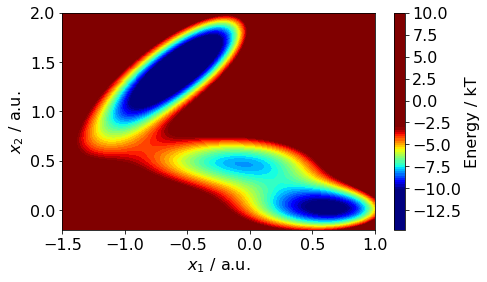

In [19]:
plot_potential()

In [19]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [22]:
nsteps = 10000
x0_left = np.array([[-0.5, 1.5]])
x0_right = np.array([[0.5, 0.0]])

sampler = MetropolisGauss(mueller, x0_left, noise=0.02, stride=10)
sampler.run(nsteps)
traj_left = sampler.traj.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.traj.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.traj.copy()

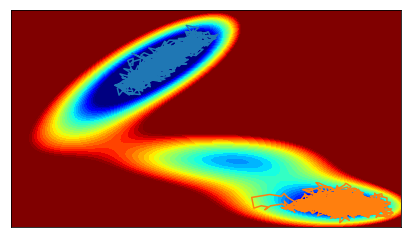

In [23]:
plot_potential(cbar=False, labels=False)
plt.plot(traj_left[:, 0], traj_left[:, 1])
plt.plot(traj_right[:, 0], traj_right[:, 1])
#plt.plot(traj_left_val[:, 0], traj_left_val[:, 1])
#plt.plot(traj_right_val[:, 0], traj_right_val[:, 1])

In [23]:
x = np.vstack([traj_left, traj_right])
xval = np.vstack([traj_left_val, traj_right_val])

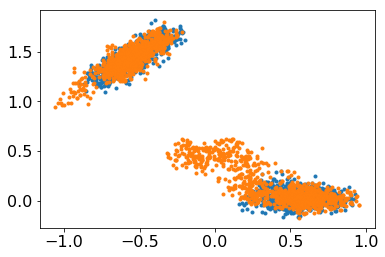

In [24]:
plt.plot(x[:, 0], x[:, 1], linewidth=0, marker='.')
plt.plot(xval[:, 0], xval[:, 1], linewidth=0, marker='.')
#plt.plot(traj_right[:, 0], traj_right[:, 1])

Particle filter starting from one sample
-----

In [25]:
x0 = traj_left[100:101]
X0 = np.repeat(x0, 1000, axis=0)
#X0 += 0.01 * np.random.randn(X0.shape[0], X0.shape[1])

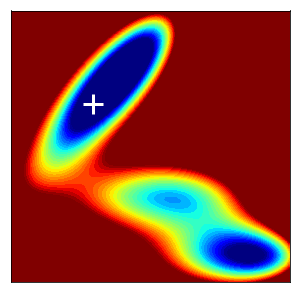

In [26]:
plot_potential(labels=False, cbar=False, figsize=(5, 5))
plt.plot(x0[:, 0], x0[:, 1], color='white', linewidth=0, marker='+', markersize=20, markeredgewidth=3)
#plt.savefig(paper_dir + 'figs/mueller/explore_potential_init.pdf', bbox_inches='tight', transparent=True)

In [27]:
bg = invnet(mueller.dim, 'RRRRR', mueller, nl_layers=3, nl_hidden=100, # RPRPRPRPR
            nl_activation='relu', nl_activation_scale='tanh')

<RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0
Instructions for updating:
Colocations handled automatically by placer.


In [28]:
loss_bg_trainML, loss_bg_valML = bg.train_ML(X0, epochs=3, batch_size=128, 
                                             std=1.0, verbose=0, return_test_energies=False)

Instructions for updating:
Use tf.cast instead.


In [29]:
from deep_boltzmann.networks.training import ParticleFilter

In [30]:
particle_filter = ParticleFilter(bg, X0, 100000, lr=0.0001, batch_size=2048, 
                                 high_energy=10000, max_energy=1e10, std=1.0, weigh_ML=True)

In [31]:
Ds = []
Ds.append(proj_diag(particle_filter.X))

In [32]:
for i in range(30):
    print('\nITER',(i+1))
    particle_filter.train(epochs=50, stepsize=None, verbose=1)
    Ds.append(proj_diag(particle_filter.X))


ITER 1
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 0/50 loss 145.5039 index_layer_3_loss 0.0366 index_layer_6_loss 145.4674 p_acc 0.2646484375 step 0.1
Epoch 1/50 loss 118.5262 index_layer_3_loss 0.0433 index_layer_6_loss 118.4829 p_acc 0.27880859375 step 0.1
Epoch 2/50 loss 80.5554 index_layer_3_loss 0.0500 index_layer_6_loss 80.5055 p_acc 0.28564453125 step 0.1
Epoch 3/50 loss 109.7766 index_layer_3_loss 0.0576 index_layer_6_loss 109.7190 p_acc 0.29052734375 step 0.1
Epoch 4/50 loss 71.4630 index_layer_3_loss 0.0656 index_layer_6_loss 71.3974 p_acc 0.29736328125 step 0.1
Epoch 5/50 loss 59.7545 index_layer_3_loss 0.0733 index_layer_6_loss 59.6812 p_acc 0.2958984375 step 0.1
Epoch 6/50 loss 74.2881 index_layer_3_loss 0.0806 index_layer_6_loss 74.2074 p_acc 0.29150390625 step 0.1
Epoch 7/50 loss 59.0649 index_layer_3_loss 0.0861 index_layer_6_loss 58.9787 p_acc 0.3037109375 step 0.1
Epoch 8/50 loss 86.9987 index_layer_3_loss 0.0895 index_layer_6

Epoch 22/50 loss 9.6765 index_layer_3_loss -0.2090 index_layer_6_loss 9.8855 p_acc 0.22412109375 step 0.15768992641913981
Epoch 23/50 loss 11.3401 index_layer_3_loss -0.2101 index_layer_6_loss 11.5502 p_acc 0.205078125 step 0.1608437249475226
Epoch 24/50 loss 9.1590 index_layer_3_loss -0.2124 index_layer_6_loss 9.3714 p_acc 0.21337890625 step 0.16406059944647305
Epoch 25/50 loss 4.8817 index_layer_3_loss -0.2173 index_layer_6_loss 5.0991 p_acc 0.21337890625 step 0.16734181143540253
Epoch 26/50 loss 5.2251 index_layer_3_loss -0.2238 index_layer_6_loss 5.4490 p_acc 0.19580078125 step 0.17068864766411057
Epoch 27/50 loss 6.0818 index_layer_3_loss -0.2261 index_layer_6_loss 6.3078 p_acc 0.20263671875 step 0.17410242061739278
Epoch 28/50 loss 7.5777 index_layer_3_loss -0.2330 index_layer_6_loss 7.8108 p_acc 0.1943359375 step 0.17758446902974065
Epoch 29/50 loss 6.2327 index_layer_3_loss -0.2344 index_layer_6_loss 6.4671 p_acc 0.17822265625 step 0.18113615841033545
Epoch 30/50 loss 7.1374 in

Epoch 40/50 loss 4.1477 index_layer_3_loss -0.3943 index_layer_6_loss 4.5421 p_acc 0.138671875 step 0.28003281854481815
Epoch 41/50 loss 1.1543 index_layer_3_loss -0.3978 index_layer_6_loss 1.5520 p_acc 0.1455078125 step 0.28003281854481815
Epoch 42/50 loss 2.1984 index_layer_3_loss -0.3941 index_layer_6_loss 2.5925 p_acc 0.1318359375 step 0.28003281854481815
Epoch 43/50 loss 1.3017 index_layer_3_loss -0.3990 index_layer_6_loss 1.7006 p_acc 0.1298828125 step 0.28003281854481815
Epoch 44/50 loss 0.8517 index_layer_3_loss -0.4032 index_layer_6_loss 1.2549 p_acc 0.1435546875 step 0.28003281854481815
Epoch 45/50 loss 1.8888 index_layer_3_loss -0.4247 index_layer_6_loss 2.3135 p_acc 0.13427734375 step 0.28003281854481815
Epoch 46/50 loss 0.9863 index_layer_3_loss -0.4088 index_layer_6_loss 1.3951 p_acc 0.13134765625 step 0.28003281854481815
Epoch 47/50 loss 1.2578 index_layer_3_loss -0.4073 index_layer_6_loss 1.6652 p_acc 0.134765625 step 0.28003281854481815
Epoch 48/50 loss 1.3103 index_la

Epoch 8/50 loss -1.0306 index_layer_3_loss -0.7241 index_layer_6_loss -0.3065 p_acc 0.1513671875 step 0.28003281854481815
Epoch 9/50 loss 0.8345 index_layer_3_loss -0.7344 index_layer_6_loss 1.5689 p_acc 0.15673828125 step 0.28003281854481815
Epoch 10/50 loss -0.3237 index_layer_3_loss -0.7512 index_layer_6_loss 0.4275 p_acc 0.14990234375 step 0.28003281854481815
Epoch 11/50 loss -0.6806 index_layer_3_loss -0.7455 index_layer_6_loss 0.0649 p_acc 0.166015625 step 0.28003281854481815
Epoch 12/50 loss -0.2604 index_layer_3_loss -0.7529 index_layer_6_loss 0.4925 p_acc 0.1669921875 step 0.28003281854481815
Epoch 13/50 loss -0.9071 index_layer_3_loss -0.7413 index_layer_6_loss -0.1658 p_acc 0.1767578125 step 0.28003281854481815
Epoch 14/50 loss -0.6412 index_layer_3_loss -0.7564 index_layer_6_loss 0.1152 p_acc 0.17626953125 step 0.28003281854481815
Epoch 15/50 loss -0.7319 index_layer_3_loss -0.7599 index_layer_6_loss 0.0280 p_acc 0.1591796875 step 0.28003281854481815
Epoch 16/50 loss -0.982

Epoch 25/50 loss -2.3003 index_layer_3_loss -1.1530 index_layer_6_loss -1.1473 p_acc 0.25341796875 step 0.2856334749157145
Epoch 26/50 loss -2.5385 index_layer_3_loss -1.1685 index_layer_6_loss -1.3700 p_acc 0.22900390625 step 0.2913461444140288
Epoch 27/50 loss -2.5184 index_layer_3_loss -1.1701 index_layer_6_loss -1.3483 p_acc 0.224609375 step 0.29717306730230936
Epoch 28/50 loss -2.6591 index_layer_3_loss -1.1784 index_layer_6_loss -1.4807 p_acc 0.23876953125 step 0.30311652864835553
Epoch 29/50 loss -2.5273 index_layer_3_loss -1.1866 index_layer_6_loss -1.3408 p_acc 0.21337890625 step 0.30917885922132265
Epoch 30/50 loss -2.8345 index_layer_3_loss -1.1819 index_layer_6_loss -1.6526 p_acc 0.21240234375 step 0.3153624364057491
Epoch 31/50 loss -2.6736 index_layer_3_loss -1.2039 index_layer_6_loss -1.4697 p_acc 0.23388671875 step 0.3216696851338641
Epoch 32/50 loss -2.6622 index_layer_3_loss -1.1978 index_layer_6_loss -1.4644 p_acc 0.212890625 step 0.32810307883654144
Epoch 33/50 loss

Epoch 43/50 loss -4.5648 index_layer_3_loss -1.6708 index_layer_6_loss -2.8941 p_acc 0.181640625 step 0.5943133126305457
Epoch 44/50 loss -4.8902 index_layer_3_loss -1.6813 index_layer_6_loss -3.2089 p_acc 0.205078125 step 0.5943133126305457
Epoch 45/50 loss -4.4930 index_layer_3_loss -1.6867 index_layer_6_loss -2.8063 p_acc 0.1875 step 0.5943133126305457
Epoch 46/50 loss -4.8985 index_layer_3_loss -1.6915 index_layer_6_loss -3.2070 p_acc 0.18505859375 step 0.5943133126305457
Epoch 47/50 loss -4.6638 index_layer_3_loss -1.6954 index_layer_6_loss -2.9684 p_acc 0.205078125 step 0.5943133126305457
Epoch 48/50 loss -4.8837 index_layer_3_loss -1.6981 index_layer_6_loss -3.1856 p_acc 0.205078125 step 0.5943133126305457
Epoch 49/50 loss -4.8192 index_layer_3_loss -1.7093 index_layer_6_loss -3.1099 p_acc 0.19189453125 step 0.5943133126305457

ITER 8
Epoch 0/50 loss -5.0160 index_layer_3_loss -1.7204 index_layer_6_loss -3.2956 p_acc 0.2021484375 step 0.5943133126305457
Epoch 1/50 loss -5.1063 i

Epoch 13/50 loss -5.5894 index_layer_3_loss -1.9647 index_layer_6_loss -3.6246 p_acc 0.1357421875 step 1.0
Epoch 14/50 loss -5.8923 index_layer_3_loss -1.9774 index_layer_6_loss -3.9149 p_acc 0.12744140625 step 1.0
Epoch 15/50 loss -5.6821 index_layer_3_loss -1.9756 index_layer_6_loss -3.7065 p_acc 0.14013671875 step 1.0
Epoch 16/50 loss -5.8732 index_layer_3_loss -1.9805 index_layer_6_loss -3.8927 p_acc 0.123046875 step 1.0
Epoch 17/50 loss -5.8063 index_layer_3_loss -1.9610 index_layer_6_loss -3.8453 p_acc 0.13037109375 step 1.0
Epoch 18/50 loss -5.5912 index_layer_3_loss -1.9613 index_layer_6_loss -3.6299 p_acc 0.13720703125 step 1.0
Epoch 19/50 loss -5.9351 index_layer_3_loss -1.9974 index_layer_6_loss -3.9377 p_acc 0.12890625 step 1.0
Epoch 20/50 loss -5.8068 index_layer_3_loss -1.9431 index_layer_6_loss -3.8637 p_acc 0.12255859375 step 1.0
Epoch 21/50 loss -5.7150 index_layer_3_loss -1.9662 index_layer_6_loss -3.7489 p_acc 0.1533203125 step 1.0
Epoch 22/50 loss -5.8542 index_laye

Epoch 40/50 loss -6.7664 index_layer_3_loss -2.2585 index_layer_6_loss -4.5079 p_acc 0.18896484375 step 1.0
Epoch 41/50 loss -6.7690 index_layer_3_loss -2.3107 index_layer_6_loss -4.4583 p_acc 0.1845703125 step 1.0
Epoch 42/50 loss -6.9079 index_layer_3_loss -2.2984 index_layer_6_loss -4.6095 p_acc 0.185546875 step 1.0
Epoch 43/50 loss -6.8721 index_layer_3_loss -2.2996 index_layer_6_loss -4.5725 p_acc 0.18408203125 step 1.0
Epoch 44/50 loss -6.8880 index_layer_3_loss -2.3039 index_layer_6_loss -4.5841 p_acc 0.171875 step 1.0
Epoch 45/50 loss -6.8347 index_layer_3_loss -2.2819 index_layer_6_loss -4.5528 p_acc 0.20068359375 step 1.0
Epoch 46/50 loss -6.9270 index_layer_3_loss -2.3254 index_layer_6_loss -4.6016 p_acc 0.19970703125 step 1.0
Epoch 47/50 loss -6.8234 index_layer_3_loss -2.3356 index_layer_6_loss -4.4878 p_acc 0.2080078125 step 1.0
Epoch 48/50 loss -6.9326 index_layer_3_loss -2.2733 index_layer_6_loss -4.6593 p_acc 0.1904296875 step 1.0
Epoch 49/50 loss -7.2016 index_layer_3

Epoch 17/50 loss -8.1416 index_layer_3_loss -2.5822 index_layer_6_loss -5.5594 p_acc 0.25048828125 step 1.0
Epoch 18/50 loss -8.2684 index_layer_3_loss -2.7486 index_layer_6_loss -5.5198 p_acc 0.26513671875 step 1.0
Epoch 19/50 loss -8.1377 index_layer_3_loss -2.6859 index_layer_6_loss -5.4518 p_acc 0.2548828125 step 1.0
Epoch 20/50 loss -8.0322 index_layer_3_loss -2.6094 index_layer_6_loss -5.4228 p_acc 0.26904296875 step 1.0
Epoch 21/50 loss -8.1261 index_layer_3_loss -2.6747 index_layer_6_loss -5.4513 p_acc 0.255859375 step 1.0
Epoch 22/50 loss -8.2203 index_layer_3_loss -2.7159 index_layer_6_loss -5.5045 p_acc 0.2490234375 step 1.0
Epoch 23/50 loss -8.1579 index_layer_3_loss -2.6353 index_layer_6_loss -5.5227 p_acc 0.27001953125 step 1.0
Epoch 24/50 loss -8.0737 index_layer_3_loss -2.6338 index_layer_6_loss -5.4399 p_acc 0.27197265625 step 1.0
Epoch 25/50 loss -8.3631 index_layer_3_loss -2.7252 index_layer_6_loss -5.6379 p_acc 0.26025390625 step 1.0
Epoch 26/50 loss -8.3947 index_l

Epoch 44/50 loss -9.5491 index_layer_3_loss -3.0524 index_layer_6_loss -6.4967 p_acc 0.32177734375 step 1.0
Epoch 45/50 loss -9.5285 index_layer_3_loss -3.0296 index_layer_6_loss -6.4988 p_acc 0.32373046875 step 1.0
Epoch 46/50 loss -9.5329 index_layer_3_loss -3.0488 index_layer_6_loss -6.4840 p_acc 0.3291015625 step 1.0
Epoch 47/50 loss -9.5101 index_layer_3_loss -3.0396 index_layer_6_loss -6.4705 p_acc 0.31982421875 step 1.0
Epoch 48/50 loss -9.2506 index_layer_3_loss -2.7670 index_layer_6_loss -6.4836 p_acc 0.34521484375 step 1.0
Epoch 49/50 loss -9.6561 index_layer_3_loss -3.0960 index_layer_6_loss -6.5601 p_acc 0.341796875 step 1.0

ITER 14
Epoch 0/50 loss -9.5045 index_layer_3_loss -2.9701 index_layer_6_loss -6.5343 p_acc 0.3232421875 step 1.0
Epoch 1/50 loss -9.4167 index_layer_3_loss -2.8282 index_layer_6_loss -6.5884 p_acc 0.337890625 step 1.0
Epoch 2/50 loss -8.7266 index_layer_3_loss -2.1681 index_layer_6_loss -6.5586 p_acc 0.31494140625 step 1.0
Epoch 3/50 loss -9.5340 inde

Epoch 21/50 loss -10.1503 index_layer_3_loss -3.0152 index_layer_6_loss -7.1351 p_acc 0.38037109375 step 1.0
Epoch 22/50 loss -9.6856 index_layer_3_loss -2.6572 index_layer_6_loss -7.0284 p_acc 0.3662109375 step 1.0
Epoch 23/50 loss -10.2683 index_layer_3_loss -3.1451 index_layer_6_loss -7.1232 p_acc 0.380859375 step 1.0
Epoch 24/50 loss -10.2870 index_layer_3_loss -3.2047 index_layer_6_loss -7.0823 p_acc 0.37548828125 step 1.0
Epoch 25/50 loss -10.2021 index_layer_3_loss -3.1119 index_layer_6_loss -7.0902 p_acc 0.3505859375 step 1.0
Epoch 26/50 loss 9.0709 index_layer_3_loss 16.3152 index_layer_6_loss -7.2443 p_acc 0.28759765625 step 1.0
Epoch 27/50 loss -9.6694 index_layer_3_loss -2.7784 index_layer_6_loss -6.8910 p_acc 0.255859375 step 1.0
Epoch 28/50 loss -8.4657 index_layer_3_loss -2.3060 index_layer_6_loss -6.1597 p_acc 0.1982421875 step 1.0
Epoch 29/50 loss -7.0221 index_layer_3_loss -1.8262 index_layer_6_loss -5.1958 p_acc 0.18359375 step 1.0
Epoch 30/50 loss -5.1800 index_laye

Epoch 48/50 loss -9.5183 index_layer_3_loss -2.9229 index_layer_6_loss -6.5954 p_acc 0.2802734375 step 1.0
Epoch 49/50 loss -9.3448 index_layer_3_loss -2.7157 index_layer_6_loss -6.6290 p_acc 0.275390625 step 1.0

ITER 17
Epoch 0/50 loss -9.5822 index_layer_3_loss -2.8724 index_layer_6_loss -6.7099 p_acc 0.28515625 step 1.0
Epoch 1/50 loss -9.6175 index_layer_3_loss -2.9447 index_layer_6_loss -6.6727 p_acc 0.27685546875 step 1.0
Epoch 2/50 loss -9.6457 index_layer_3_loss -2.9895 index_layer_6_loss -6.6562 p_acc 0.30419921875 step 1.0
Epoch 3/50 loss -9.4081 index_layer_3_loss -2.6675 index_layer_6_loss -6.7407 p_acc 0.3095703125 step 1.0
Epoch 4/50 loss -9.5047 index_layer_3_loss -2.6693 index_layer_6_loss -6.8354 p_acc 0.298828125 step 1.0
Epoch 5/50 loss -9.7941 index_layer_3_loss -3.0318 index_layer_6_loss -6.7623 p_acc 0.30712890625 step 1.0
Epoch 6/50 loss -9.8197 index_layer_3_loss -3.0567 index_layer_6_loss -6.7630 p_acc 0.3125 step 1.0
Epoch 7/50 loss -9.7123 index_layer_3_loss

Epoch 25/50 loss -10.1639 index_layer_3_loss -2.9954 index_layer_6_loss -7.1686 p_acc 0.31494140625 step 1.0
Epoch 26/50 loss -10.2300 index_layer_3_loss -3.0924 index_layer_6_loss -7.1376 p_acc 0.326171875 step 1.0
Epoch 27/50 loss -10.1312 index_layer_3_loss -2.9284 index_layer_6_loss -7.2028 p_acc 0.34814453125 step 1.0
Epoch 28/50 loss -10.2089 index_layer_3_loss -2.9561 index_layer_6_loss -7.2528 p_acc 0.32958984375 step 1.0
Epoch 29/50 loss -9.4960 index_layer_3_loss -2.3359 index_layer_6_loss -7.1602 p_acc 0.3427734375 step 1.0
Epoch 30/50 loss -10.3639 index_layer_3_loss -3.0705 index_layer_6_loss -7.2934 p_acc 0.3603515625 step 1.0
Epoch 31/50 loss -10.3634 index_layer_3_loss -3.2360 index_layer_6_loss -7.1274 p_acc 0.357421875 step 1.0
Epoch 32/50 loss -9.9584 index_layer_3_loss -2.9379 index_layer_6_loss -7.0205 p_acc 0.341796875 step 1.0
Epoch 33/50 loss -10.1055 index_layer_3_loss -2.9086 index_layer_6_loss -7.1969 p_acc 0.34814453125 step 1.0
Epoch 34/50 loss -10.3955 ind

/Users/noe/data/software_projects/deep_boltzmann/deep_boltzmann/models/mueller_potential.py:44: RuntimeWarning: overflow encountered in exp
  self.cc[j] * (x2 - self.YY[j])**2)


Epoch 32/50 loss -10.4358 index_layer_3_loss -3.0728 index_layer_6_loss -7.3630 p_acc 0.37060546875 step 1.0
Epoch 33/50 loss -10.8443 index_layer_3_loss -3.2741 index_layer_6_loss -7.5701 p_acc 0.3740234375 step 1.0
Epoch 34/50 loss -10.3541 index_layer_3_loss -3.0106 index_layer_6_loss -7.3435 p_acc 0.3671875 step 1.0
Epoch 35/50 loss -10.5200 index_layer_3_loss -3.0626 index_layer_6_loss -7.4574 p_acc 0.37060546875 step 1.0
Epoch 36/50 loss -10.4302 index_layer_3_loss -2.9678 index_layer_6_loss -7.4625 p_acc 0.36865234375 step 1.0
Epoch 37/50 loss -10.5187 index_layer_3_loss -3.0073 index_layer_6_loss -7.5115 p_acc 0.36767578125 step 1.0
Epoch 38/50 loss -10.6476 index_layer_3_loss -3.1650 index_layer_6_loss -7.4826 p_acc 0.36376953125 step 1.0
Epoch 39/50 loss -10.4713 index_layer_3_loss -3.0216 index_layer_6_loss -7.4497 p_acc 0.36865234375 step 1.0
Epoch 40/50 loss -5.3429 index_layer_3_loss -2.8404 index_layer_6_loss -2.5025 p_acc 0.376953125 step 1.0
Epoch 41/50 loss -10.5493 i

Epoch 8/50 loss -10.7101 index_layer_3_loss -3.1274 index_layer_6_loss -7.5827 p_acc 0.3603515625 step 1.0
Epoch 9/50 loss -10.5097 index_layer_3_loss -3.0919 index_layer_6_loss -7.4179 p_acc 0.37060546875 step 1.0
Epoch 10/50 loss -9.5166 index_layer_3_loss -2.0486 index_layer_6_loss -7.4680 p_acc 0.35791015625 step 1.0
Epoch 11/50 loss -10.5331 index_layer_3_loss -3.0300 index_layer_6_loss -7.5031 p_acc 0.34130859375 step 1.0
Epoch 12/50 loss -10.5887 index_layer_3_loss -3.1874 index_layer_6_loss -7.4012 p_acc 0.3134765625 step 1.0
Epoch 13/50 loss -10.4423 index_layer_3_loss -3.0156 index_layer_6_loss -7.4267 p_acc 0.33984375 step 1.0
Epoch 14/50 loss -10.0976 index_layer_3_loss -2.7770 index_layer_6_loss -7.3206 p_acc 0.3212890625 step 1.0
Epoch 15/50 loss -10.2822 index_layer_3_loss -3.0066 index_layer_6_loss -7.2756 p_acc 0.30859375 step 1.0
Epoch 16/50 loss -9.6138 index_layer_3_loss -2.3848 index_layer_6_loss -7.2289 p_acc 0.31591796875 step 1.0
Epoch 17/50 loss -10.4016 index_

Epoch 35/50 loss -10.7467 index_layer_3_loss -3.1525 index_layer_6_loss -7.5943 p_acc 0.38525390625 step 1.0
Epoch 36/50 loss -10.8290 index_layer_3_loss -3.1349 index_layer_6_loss -7.6941 p_acc 0.36669921875 step 1.0
Epoch 37/50 loss -10.6617 index_layer_3_loss -3.1330 index_layer_6_loss -7.5287 p_acc 0.36474609375 step 1.0
Epoch 38/50 loss -10.4862 index_layer_3_loss -2.9515 index_layer_6_loss -7.5347 p_acc 0.37353515625 step 1.0
Epoch 39/50 loss -10.7854 index_layer_3_loss -3.0687 index_layer_6_loss -7.7167 p_acc 0.3662109375 step 1.0
Epoch 40/50 loss -10.8135 index_layer_3_loss -3.1759 index_layer_6_loss -7.6377 p_acc 0.38623046875 step 1.0
Epoch 41/50 loss -10.6255 index_layer_3_loss -3.0219 index_layer_6_loss -7.6036 p_acc 0.36962890625 step 1.0
Epoch 42/50 loss -10.6243 index_layer_3_loss -3.0852 index_layer_6_loss -7.5392 p_acc 0.36474609375 step 1.0
Epoch 43/50 loss -5.8160 index_layer_3_loss -3.1218 index_layer_6_loss -2.6942 p_acc 0.3623046875 step 1.0
Epoch 44/50 loss -10.7

Epoch 11/50 loss -10.6205 index_layer_3_loss -2.9240 index_layer_6_loss -7.6965 p_acc 0.37744140625 step 1.0
Epoch 12/50 loss -10.3198 index_layer_3_loss -2.5151 index_layer_6_loss -7.8047 p_acc 0.40087890625 step 1.0
Epoch 13/50 loss -10.8685 index_layer_3_loss -3.1138 index_layer_6_loss -7.7547 p_acc 0.39208984375 step 1.0
Epoch 14/50 loss -10.8920 index_layer_3_loss -3.0598 index_layer_6_loss -7.8322 p_acc 0.38623046875 step 1.0
Epoch 15/50 loss -10.7748 index_layer_3_loss -2.8979 index_layer_6_loss -7.8769 p_acc 0.3837890625 step 1.0
Epoch 16/50 loss -10.5294 index_layer_3_loss -2.6471 index_layer_6_loss -7.8822 p_acc 0.4052734375 step 1.0
Epoch 17/50 loss -10.6959 index_layer_3_loss -2.8493 index_layer_6_loss -7.8466 p_acc 0.3828125 step 1.0
Epoch 18/50 loss -10.6984 index_layer_3_loss -2.8798 index_layer_6_loss -7.8185 p_acc 0.38037109375 step 1.0
Epoch 19/50 loss -10.5600 index_layer_3_loss -2.6865 index_layer_6_loss -7.8735 p_acc 0.39990234375 step 1.0
Epoch 20/50 loss -10.6721

Epoch 37/50 loss -4.6220 index_layer_3_loss -1.3078 index_layer_6_loss -3.3142 p_acc 0.15771484375 step 1.0
Epoch 38/50 loss -4.2717 index_layer_3_loss -1.2428 index_layer_6_loss -3.0289 p_acc 0.177734375 step 1.0
Epoch 39/50 loss -3.8389 index_layer_3_loss -1.1898 index_layer_6_loss -2.6491 p_acc 0.162109375 step 1.0
Epoch 40/50 loss -3.2929 index_layer_3_loss -1.0590 index_layer_6_loss -2.2339 p_acc 0.16845703125 step 1.0
Epoch 41/50 loss -3.4005 index_layer_3_loss -1.1363 index_layer_6_loss -2.2643 p_acc 0.1494140625 step 1.0
Epoch 42/50 loss -3.0448 index_layer_3_loss -0.9676 index_layer_6_loss -2.0772 p_acc 0.16015625 step 1.0
Epoch 43/50 loss -3.2018 index_layer_3_loss -1.1462 index_layer_6_loss -2.0556 p_acc 0.146484375 step 1.0
Epoch 44/50 loss -3.1250 index_layer_3_loss -1.1981 index_layer_6_loss -1.9269 p_acc 0.16015625 step 1.0
Epoch 45/50 loss -3.4251 index_layer_3_loss -1.2246 index_layer_6_loss -2.2005 p_acc 0.154296875 step 1.0
Epoch 46/50 loss -3.3927 index_layer_3_loss

Epoch 14/50 loss -9.6524 index_layer_3_loss -2.8036 index_layer_6_loss -6.8489 p_acc 0.29736328125 step 1.0
Epoch 15/50 loss -9.8164 index_layer_3_loss -2.8884 index_layer_6_loss -6.9281 p_acc 0.3115234375 step 1.0
Epoch 16/50 loss -9.9737 index_layer_3_loss -2.8893 index_layer_6_loss -7.0844 p_acc 0.2890625 step 1.0
Epoch 17/50 loss -9.9017 index_layer_3_loss -2.8548 index_layer_6_loss -7.0469 p_acc 0.306640625 step 1.0
Epoch 18/50 loss -10.0777 index_layer_3_loss -3.0318 index_layer_6_loss -7.0459 p_acc 0.30810546875 step 1.0
Epoch 19/50 loss -10.1673 index_layer_3_loss -2.9911 index_layer_6_loss -7.1762 p_acc 0.29638671875 step 1.0
Epoch 20/50 loss -9.9936 index_layer_3_loss -3.0203 index_layer_6_loss -6.9733 p_acc 0.30419921875 step 1.0
Epoch 21/50 loss -10.1845 index_layer_3_loss -3.0043 index_layer_6_loss -7.1802 p_acc 0.2939453125 step 1.0
Epoch 22/50 loss -10.0736 index_layer_3_loss -3.0191 index_layer_6_loss -7.0544 p_acc 0.31201171875 step 1.0
Epoch 23/50 loss -10.0393 index_

Epoch 40/50 loss -10.6779 index_layer_3_loss -3.2122 index_layer_6_loss -7.4657 p_acc 0.3544921875 step 1.0
Epoch 41/50 loss -10.6355 index_layer_3_loss -3.1493 index_layer_6_loss -7.4862 p_acc 0.34423828125 step 1.0
Epoch 42/50 loss -10.6438 index_layer_3_loss -3.0794 index_layer_6_loss -7.5644 p_acc 0.34033203125 step 1.0
Epoch 43/50 loss -10.7377 index_layer_3_loss -3.1668 index_layer_6_loss -7.5709 p_acc 0.3447265625 step 1.0
Epoch 44/50 loss -10.8373 index_layer_3_loss -3.1926 index_layer_6_loss -7.6447 p_acc 0.35107421875 step 1.0
Epoch 45/50 loss -10.7307 index_layer_3_loss -3.1447 index_layer_6_loss -7.5861 p_acc 0.33203125 step 1.0
Epoch 46/50 loss -10.7121 index_layer_3_loss -3.1531 index_layer_6_loss -7.5590 p_acc 0.3681640625 step 1.0
Epoch 47/50 loss -10.6587 index_layer_3_loss -3.1661 index_layer_6_loss -7.4927 p_acc 0.34619140625 step 1.0
Epoch 48/50 loss -10.6584 index_layer_3_loss -3.2370 index_layer_6_loss -7.4214 p_acc 0.3359375 step 1.0
Epoch 49/50 loss -10.9246 ind

Epoch 16/50 loss -10.7990 index_layer_3_loss -3.1838 index_layer_6_loss -7.6151 p_acc 0.3642578125 step 1.0
Epoch 17/50 loss -10.7764 index_layer_3_loss -3.0971 index_layer_6_loss -7.6794 p_acc 0.35986328125 step 1.0
Epoch 18/50 loss -10.8466 index_layer_3_loss -3.1596 index_layer_6_loss -7.6870 p_acc 0.38330078125 step 1.0
Epoch 19/50 loss -10.7392 index_layer_3_loss -3.1262 index_layer_6_loss -7.6130 p_acc 0.3876953125 step 1.0
Epoch 20/50 loss -10.8495 index_layer_3_loss -3.0810 index_layer_6_loss -7.7685 p_acc 0.365234375 step 1.0
Epoch 21/50 loss -10.9019 index_layer_3_loss -3.2145 index_layer_6_loss -7.6874 p_acc 0.3759765625 step 1.0
Epoch 22/50 loss -10.6071 index_layer_3_loss -2.9902 index_layer_6_loss -7.6170 p_acc 0.37060546875 step 1.0
Epoch 23/50 loss -10.5986 index_layer_3_loss -2.9659 index_layer_6_loss -7.6327 p_acc 0.369140625 step 1.0
Epoch 24/50 loss -10.9010 index_layer_3_loss -3.1917 index_layer_6_loss -7.7092 p_acc 0.38232421875 step 1.0
Epoch 25/50 loss -10.9012 

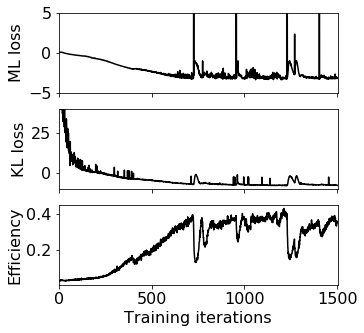

In [41]:
fig, axes = plot_convergence(particle_filter.loss_train, particle_filter.acceptance_rate, particle_filter.stepsize[1:], figsize=(5, 5));
axes[0].set_ylim(-5, 5)
axes[1].set_ylim(-10, 40)
#plt.savefig(paper_dir + 'figs/mueller/explore_conv.pdf', bbox_inches='tight')

In [44]:
#particle_filter.stepsize = list(np.concatenate([np.repeat(0.1, 61), particle_filter.stepsize]))
len(particle_filter.stepsize)

500

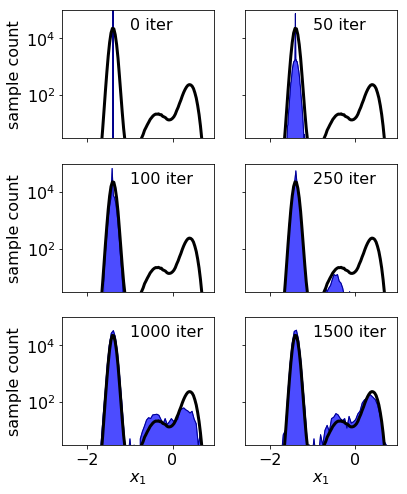

In [45]:
plot_indices = np.array([0, 1, 2, 5, 20, 30])
x_true, p_true = proj_equilibrium_density()
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(6,8))
for i, ax in zip(plot_indices, axes.flatten()):
    h, e = np.histogram(Ds[i], bins=50)
    e = 0.5*(e[:-1] + e[1:])
    ax.plot(e, h, color='darkblue', linewidth=1)
    ax.fill_between(e, np.zeros(len(e)), h, color='blue', alpha=0.7)
    ax.text(-1, 20000, str(i*50)+' iter')
    ax.plot(x_true, 10*p_true, color='black', linewidth=3, label='Eq. dist.')
    ax.semilogy()
    #plt.legend(ncol=1, fontsize=16, frameon=False)
    ax.set_ylim(3, 100000)
axes[-1, 0].set_xlabel('$x_1$')
axes[-1, 1].set_xlabel('$x_1$')
axes[0, 0].set_ylabel('sample count')
axes[1, 0].set_ylabel('sample count')
axes[2, 0].set_ylabel('sample count')
#plt.savefig(paper_dir + 'figs/mueller/explore_conv_hist.pdf', bbox_inches='tight')